
# 🚦 Sistema de Predicción de Infracciones de Tránsito  
### Tesis - Módulo de Machine Learning  
**Autor:** *[José]*  
**Objetivo:** Predecir reincidencia y riesgo de accidente en conductores a partir de infracciones de tránsito simuladas.

---
## 1️⃣ Instalación y configuración del entorno
Instalamos todas las librerías necesarias para la ejecución en **Google Colab**.


In [1]:

!pip install -q pandas numpy scikit-learn matplotlib seaborn joblib xgboost



## 2️⃣ Importación de librerías y configuración global
Incluye librerías de análisis, visualización y modelos de Machine Learning.


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10,6)

print("✅ Librerías importadas correctamente.")


ModuleNotFoundError: No module named 'pandas'


## 3️⃣ Generación del dataset sintético de infracciones

Creamos un dataset con datos simulados pero realistas de infracciones de tránsito:  
- Placas únicas  
- Tipos de infracciones  
- Gravedad, velocidad, hora, etc.  


In [ ]:

def generar_dataset_infracciones(n_vehiculos=500, n_infracciones=2000):
    np.random.seed(42)
    letras = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    placas = [f"{np.random.choice(list(letras))}{np.random.choice(list(letras))}{np.random.choice(list(letras))}-{np.random.randint(100, 999)}"
              for _ in range(n_vehiculos)]

    tipos_infraccion = [
        'LUZ_ROJA', 'EXCESO_VELOCIDAD', 'ESTACIONAMIENTO_PROHIBIDO',
        'USO_CELULAR', 'NO_CINTURON', 'GIRO_PROHIBIDO',
        'INVASION_CARRIL', 'NO_RESPETAR_PASO_PEATONAL'
    ]

    gravedades = ['LEVE', 'MODERADA', 'GRAVE', 'MUY_GRAVE']
    tipos_vehiculo = ['AUTO', 'MOTO', 'CAMION', 'BUS']

    data = []
    for _ in range(n_infracciones):
        placa = np.random.choice(placas)
        tipo = np.random.choice(tipos_infraccion, p=[0.15, 0.25, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
        gravedad = np.random.choice(gravedades, p=[0.4, 0.3, 0.2, 0.1])
        tipo_vehiculo = np.random.choice(tipos_vehiculo, p=[0.6, 0.25, 0.1, 0.05])
        velocidad = np.random.normal(60, 15)
        fecha = datetime.now() - timedelta(days=np.random.randint(0, 365))
        hora = np.random.randint(0, 24)

        data.append([placa, tipo, gravedad, tipo_vehiculo, velocidad, fecha, hora])

    df = pd.DataFrame(data, columns=['placa', 'tipo_infraccion', 'gravedad', 'tipo_vehiculo', 'velocidad', 'fecha_hora', 'hora'])
    return df

df_infracciones = generar_dataset_infracciones()
df_infracciones.head()



## 4️⃣ Análisis exploratorio de datos (EDA)
Visualizamos la distribución de tipos de infracciones, gravedad y tipos de vehículos.


Total de infracciones: 2000
Vehículos únicos: 492


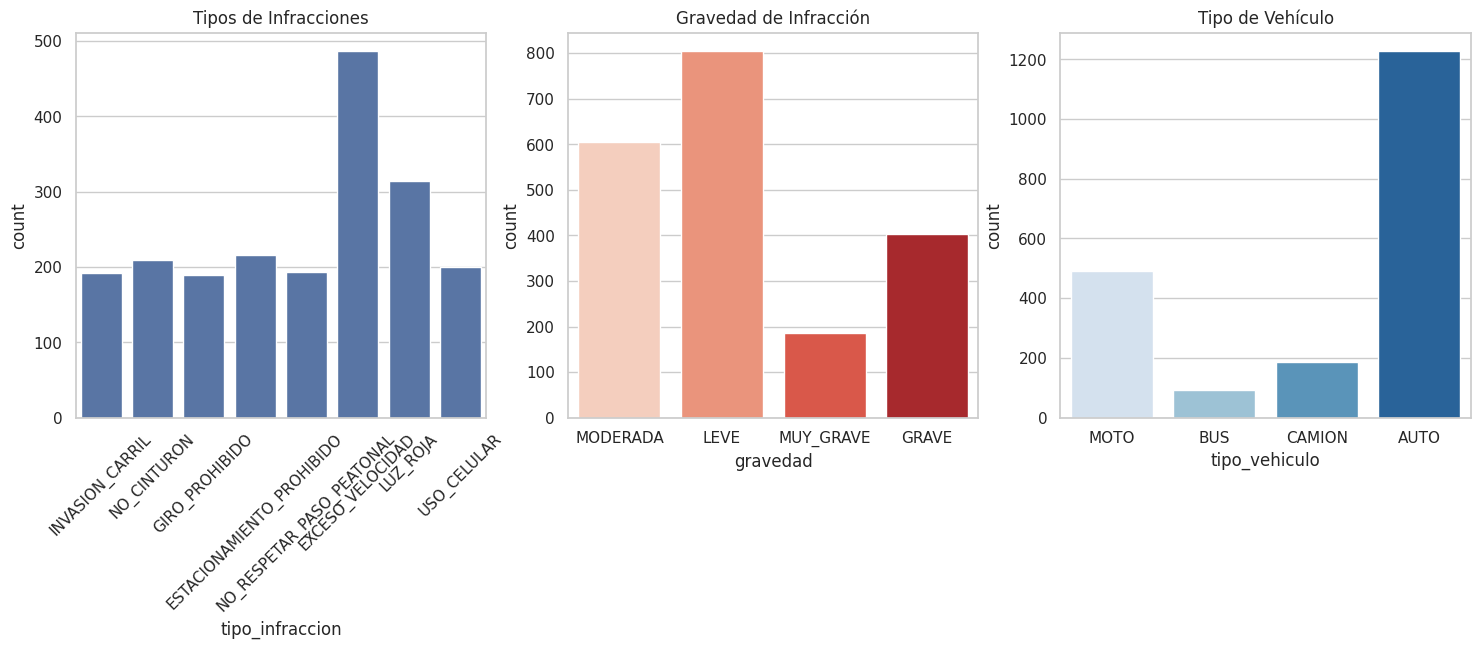

In [4]:

print("Total de infracciones:", len(df_infracciones))
print("Vehículos únicos:", df_infracciones['placa'].nunique())

fig, axes = plt.subplots(1, 3, figsize=(18,5))
sns.countplot(data=df_infracciones, x='tipo_infraccion', ax=axes[0])
axes[0].set_title('Tipos de Infracciones')
axes[0].tick_params(axis='x', rotation=45)

sns.countplot(data=df_infracciones, x='gravedad', ax=axes[1], palette='Reds')
axes[1].set_title('Gravedad de Infracción')

sns.countplot(data=df_infracciones, x='tipo_vehiculo', ax=axes[2], palette='Blues')
axes[2].set_title('Tipo de Vehículo')
plt.show()



## 5️⃣ Ingeniería de características
Agrupamos las infracciones por vehículo y calculamos variables agregadas útiles para el modelo.


In [7]:
def crear_features_vehiculo(df):
    features = []
    for placa in df['placa'].unique():
        df_v = df[df['placa'] == placa].sort_values('fecha_hora')
        total = len(df_v)
        graves = len(df_v[df_v['gravedad'].isin(['GRAVE', 'MUY_GRAVE'])])
        leves = total - graves
        velocidad_prom = df_v['velocidad'].mean()

        # Evitar división por cero (si todas las infracciones ocurrieron el mismo día)
        dias_diferencia = (df_v['fecha_hora'].max() - df_v['fecha_hora'].min()).days
        if dias_diferencia == 0:
            infracciones_mes = total  # asumimos todas en un mismo mes
        else:
            infracciones_mes = (total / dias_diferencia) * 30

        hora_promedio = df_v['hora'].mean()

        es_reincidente = 1 if total > np.random.randint(3, 8) else 0
        alto_riesgo = 1 if graves / total > 0.4 else 0

        features.append([
            placa, total, graves, leves,
            velocidad_prom, infracciones_mes, hora_promedio,
            es_reincidente, alto_riesgo
        ])

    cols = [
        'placa', 'total_infracciones', 'infracciones_graves', 'infracciones_leves',
        'velocidad_promedio', 'tasa_infracciones_mes', 'hora_promedio',
        'es_reincidente', 'alto_riesgo_accidente'
    ]
    return pd.DataFrame(features, columns=cols)

# Ejecutar nuevamente
df_features = crear_features_vehiculo(df_infracciones)
df_features.head()


,placa,total_infracciones,infracciones_graves,infracciones_leves,velocidad_promedio,tasa_infracciones_mes,hora_promedio,es_reincidente,alto_riesgo_accidente
0,DSZ-128,3,0,3,74.505721,0.432692,12.333333,0,0
1,HTC-211,6,1,5,61.323761,0.994475,17.500000,0,0
2,VWV-849,6,2,4,57.002658,0.705882,14.833333,1,0
3,NRZ-876,3,0,3,57.744026,1.666667,5.666667,0,0
4,UFF-602,1,0,1,64.045040,1.000000,7.000000,0,0



## 6️⃣ Entrenamiento y comparación de modelos
Entrenamos varios clasificadores para predecir la **reincidencia**.


In [8]:

X = df_features[['total_infracciones','infracciones_graves','infracciones_leves','velocidad_promedio','tasa_infracciones_mes','hora_promedio']]
y = df_features['es_reincidente']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

modelos = {
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=200, random_state=42, max_depth=5, learning_rate=0.1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=200, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

resultados = {}
for nombre, modelo in modelos.items():
    modelo.fit(X_train_scaled, y_train)
    y_pred = modelo.predict(X_test_scaled)
    y_proba = modelo.predict_proba(X_test_scaled)[:,1]
    resultados[nombre] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, y_proba)
    }

df_resultados = pd.DataFrame(resultados).T.sort_values('auc', ascending=False)
df_resultados


,accuracy,auc
Random Forest,0.858586,0.906121
Logistic Regression,0.828283,0.897119
Gradient Boosting,0.818182,0.879115
XGBoost,0.797980,0.858539



## 7️⃣ Evaluación detallada del mejor modelo
Mostramos métricas y matriz de confusión del modelo con mayor AUC.


🏆 Mejor modelo: Random Forest
                precision    recall  f1-score   support

No Reincidente       0.88      0.93      0.91        72
   Reincidente       0.78      0.67      0.72        27

      accuracy                           0.86        99
     macro avg       0.83      0.80      0.81        99
  weighted avg       0.85      0.86      0.85        99



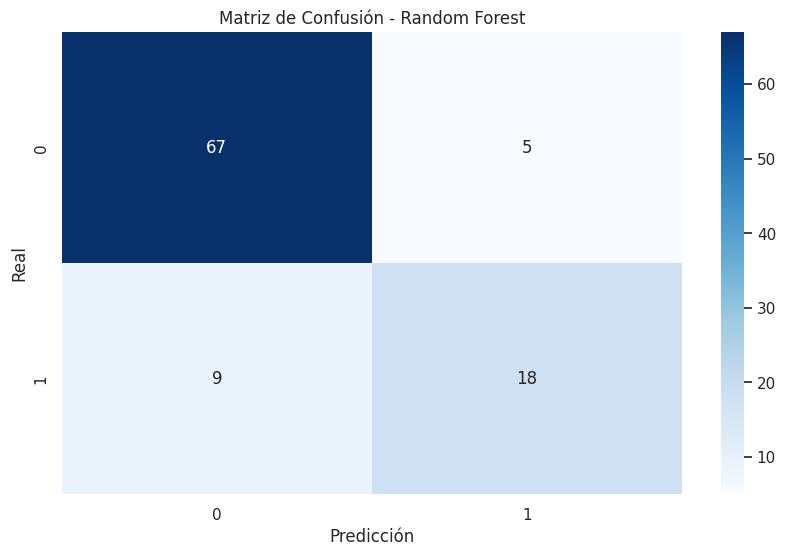

In [9]:

mejor_modelo_nombre = df_resultados.index[0]
print(f"🏆 Mejor modelo: {mejor_modelo_nombre}")

mejor_modelo = modelos[mejor_modelo_nombre]
y_pred = mejor_modelo.predict(X_test_scaled)

print(classification_report(y_test, y_pred, target_names=['No Reincidente', 'Reincidente']))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Matriz de Confusión - {mejor_modelo_nombre}")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()



## 8️⃣ Guardado de modelos y escalador
Guardamos los artefactos entrenados para integrarlos posteriormente con el sistema IoT o API.


In [10]:

joblib.dump(mejor_modelo, 'modelo_reincidencia.pkl')
joblib.dump(scaler, 'scaler.pkl')
with open('feature_names.json', 'w') as f:
    json.dump(list(X.columns), f)

print("✅ Modelos y escalador guardados correctamente.")


✅ Modelos y escalador guardados correctamente.
